In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_recall_curve, accuracy_score, f1_score

In [2]:
# Load the finalized dataset
df = pd.read_csv("../Datasets/pokedex_final.csv")

# Combine type1 and type2 into a list
df['type_list'] = df[['type1', 'type2']].values.tolist()
df['type_list'] = df['type_list'].apply(lambda x: [t for t in x if pd.notna(t) and t != ''])

# Encode the types with MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['type_list'])

# Tokenize the enhanced_info column
text_tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
text_tokenizer.fit_on_texts(df['enhanced_info'])

sequences = text_tokenizer.texts_to_sequences(df['enhanced_info'])
X_text = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')

# Normalize numeric features
stats_cols = ['hp', 'attack', 'defense', 's_attack', 'speed', 'height', 'weight']
scaler = StandardScaler()
X_stats = scaler.fit_transform(df[stats_cols])

In [3]:
# Text input
input_text = Input(shape=(300,), name='text_input')
text_embed = Embedding(input_dim=5000, output_dim=64, input_length=300)(input_text)

# Bidirectional LSTM
text_lstm = Bidirectional(LSTM(128, dropout=0.2))(text_embed)

# Stats input
input_stats = Input(shape=(X_stats.shape[1],), name='stats_input')

# Combine
combined = Concatenate()([text_lstm, input_stats])

# Hidden dense layer
hidden = Dense(256, activation='relu')(combined)

# >>> ADD Dropout after hidden layer
hidden = Dropout(0.5)(hidden)

# Output
output = Dense(len(mlb.classes_), activation='sigmoid')(hidden)

# Build model
model = Model(inputs=[input_text, input_stats], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Calculate class weights based on label frequency
class_totals = y.sum(axis=0)
class_weights = y.shape[0] / (len(mlb.classes_) * class_totals)

# Convert class weights to numpy array
class_weights = np.array(class_weights)

# Print class weights to check
print(dict(zip(mlb.classes_, class_weights)))

# Train-Test Split
X_train_text, X_test_text, X_train_stats, X_test_stats, y_train, y_test = train_test_split(
    X_text, X_stats, y, test_size=0.2, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Now fit the model with early stopping
history = model.fit(
    [X_train_text, X_train_stats],
    y_train,
    validation_data=([X_test_text, X_test_stats], y_test),
    epochs=100,
    batch_size=32,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[early_stop]  # <<< ADD this!
)

c:\Users\arvee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 64)   │    320,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    197,632 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stats_input         │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 263)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ stats_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     67,584 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 18)        │      4,626 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 589,842 (2.25 MB)

 Trainable params: 589,842 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

{'bug': 0.6189613526570048, 'dark': 0.8252818035426731, 'dragon': 0.8134920634920635, 'electric': 0.8252818035426731, 'fairy': 0.8897569444444444, 'fighting': 0.7800608828006088, 'fire': 0.7030178326474623, 'flying': 0.5224260958205912, 'ghost': 0.8760683760683761, 'grass': 0.4483814523184602, 'ground': 0.7592592592592593, 'ice': 1.1863425925925926, 'normal': 0.43469041560644617, 'poison': 0.6860776439089692, 'psychic': 0.5582788671023965, 'rock': 0.7695195195195195, 'steel': 0.8760683760683761, 'water': 0.36976911976911975}
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 282ms/step - accuracy: 0.0475 - loss: 0.3592 - val_accuracy: 0.0780 - val_loss: 0.2858
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.0820 - loss: 0.2081 - val_accuracy: 0.1122 - val_loss: 0.2803
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step - accuracy: 0.0715 - loss: 0.2026 - val_accuracy: 0.1122 - val_loss: 0.2783
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.0901 - loss: 0

In [4]:
from sklearn.metrics import f1_score
import numpy as np

# --- Load the saved model
model = tf.keras.models.load_model("rnn_stats_pokemon_model.keras")

# --- Predict on test set
y_pred_probs = model.predict([X_test_text, X_test_stats])

# --- Load 'is_dual_type' for test set
# You must split it the same way you split X and y
# If you haven't yet, do this:

is_dual = (df['type2'].notna()).astype(int)  # 1 if dual type, 0 if mono
_, is_dual_test = train_test_split(is_dual, test_size=0.2, random_state=42)

# --- Predict function: top-1 or top-2 based on is_dual_type
def predict_types_v2(probs_batch, is_dual_batch):
    preds = []
    for probs, is_dual in zip(probs_batch, is_dual_batch):
        if is_dual:
            top2 = np.argsort(probs)[-2:]
            pred = np.zeros_like(probs)
            pred[top2] = 1
        else:
            top1 = np.argmax(probs)
            pred = np.zeros_like(probs)
            pred[top1] = 1
        preds.append(pred)
    return np.array(preds)

# --- Get predicted labels
y_pred_labels = predict_types_v2(y_pred_probs, is_dual_test)

# --- Evaluate
macro_f1 = f1_score(y_test, y_pred_labels, average='macro')
weighted_f1 = f1_score(y_test, y_pred_labels, average='weighted')

print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# --- Calculate Top-2 Accuracy
def top_2_accuracy(y_true, y_pred):
    correct = 0
    for true, pred in zip(y_true, y_pred):
        if np.dot(true, pred) > 0:  # If any correct label is predicted
            correct += 1
    return correct / len(y_true)

top2_acc = top_2_accuracy(y_test, y_pred_labels)
print(f"Top-2 Accuracy: {top2_acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Macro F1 Score: 0.3028
Weighted F1 Score: 0.2986
Top-2 Accuracy: 0.4488


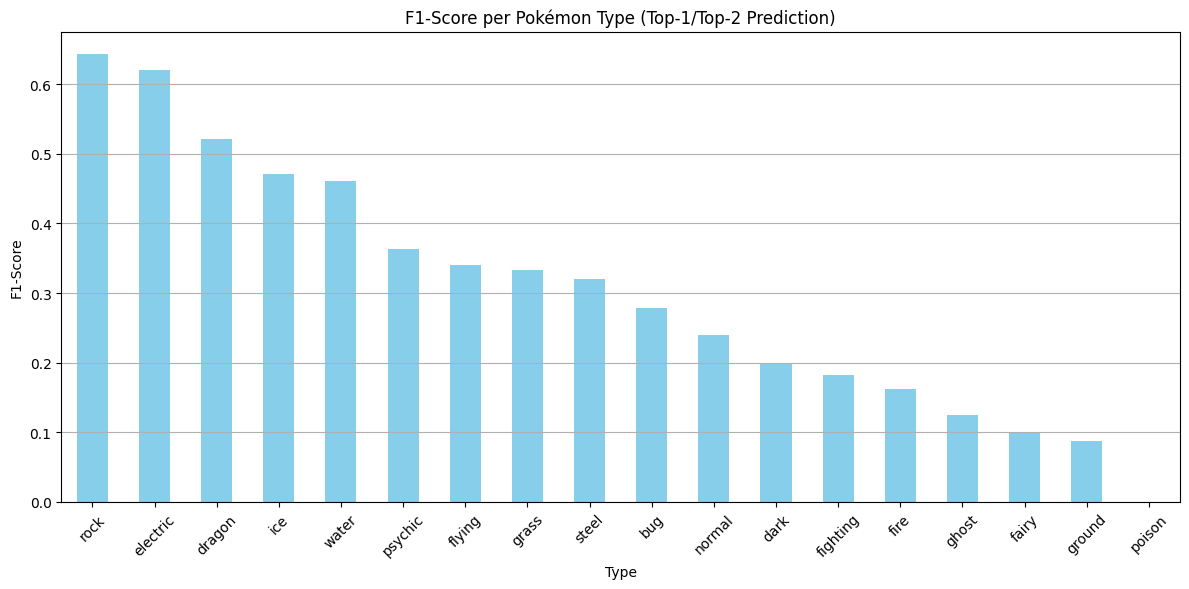

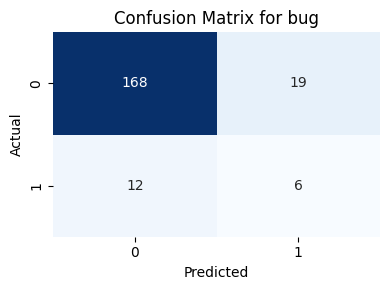

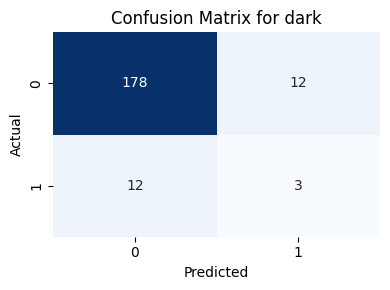

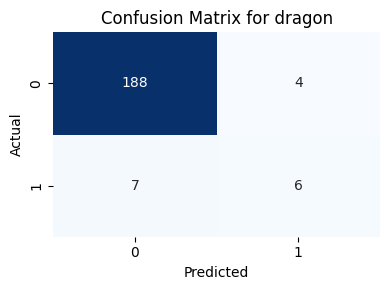

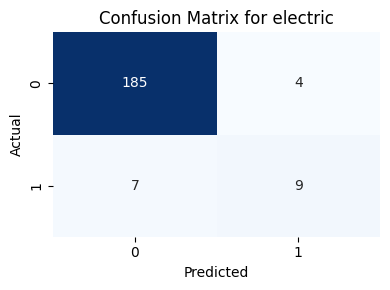

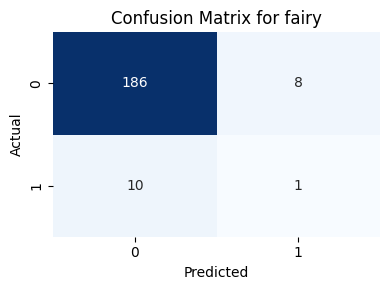

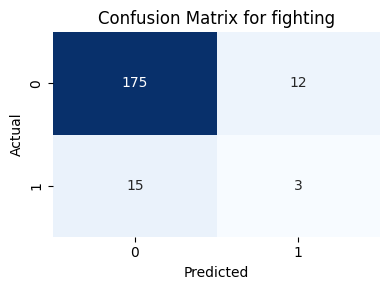

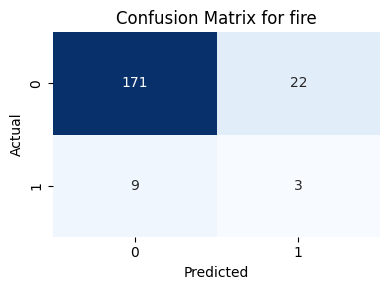

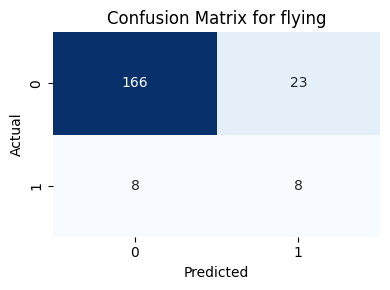

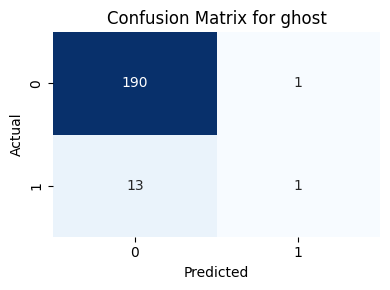

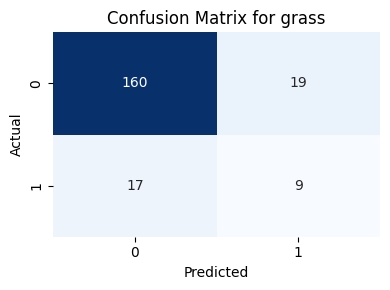

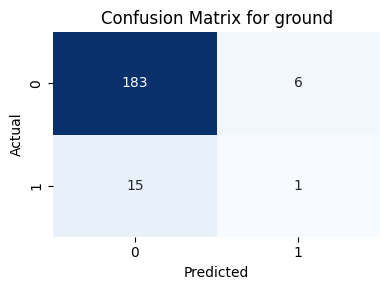

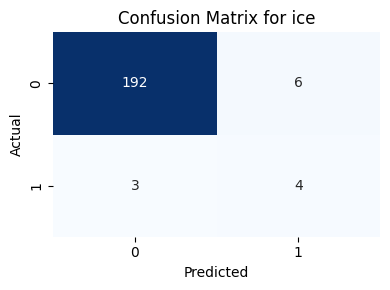

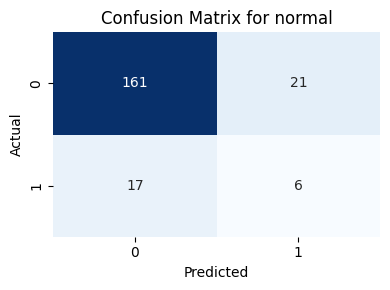

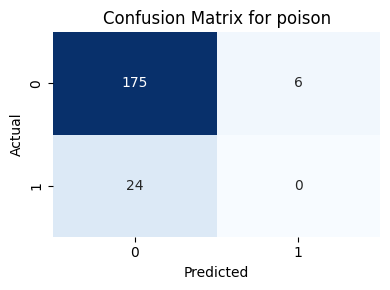

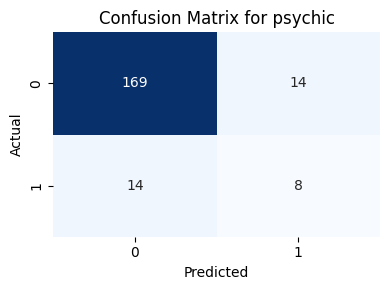

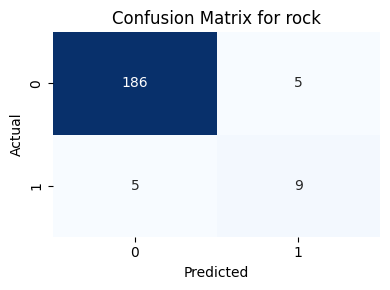

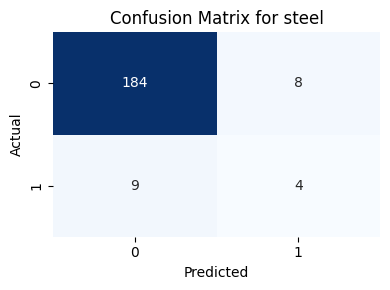

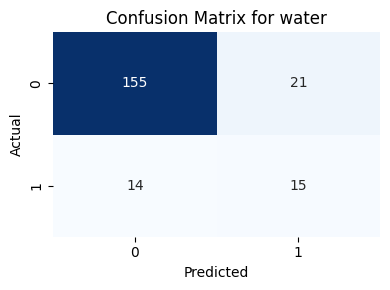

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# Classification Report (per-type F1 scores)
report = classification_report(
    y_test,
    y_pred_labels,
    target_names=mlb.classes_,
    output_dict=True
)

# Convert to DataFrame for plotting
report_df = pd.DataFrame(report).transpose()

# Plot F1 scores per type
f1_scores = report_df.loc[mlb.classes_, 'f1-score']
plt.figure(figsize=(12,6))
f1_scores.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('F1-Score per Pokémon Type (Top-1/Top-2 Prediction)')
plt.ylabel('F1-Score')
plt.xlabel('Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Multilabel confusion matrices
conf_matrices = multilabel_confusion_matrix(y_test, y_pred_labels)

# Plot each one
for idx, type_name in enumerate(mlb.classes_):
    cm = conf_matrices[idx]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {type_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [6]:
y_pred_probs = model.predict([X_test_text, X_test_stats])
print("Max prob:", np.max(y_pred_probs))
print("Mean prob:", np.mean(y_pred_probs))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Max prob: 0.88602835
Mean prob: 0.07600009


In [14]:
import numpy as np

pred_counts = y_pred_labels.sum(axis=0)
true_counts = y_test.sum(axis=0)

for cls, pred, true in zip(mlb.classes_, pred_counts, true_counts):
    print(f"{cls:10s} | predicted: {int(pred):3d} | actual: {int(true):3d}")

bug        | predicted:  25 | actual:  18
dark       | predicted:  15 | actual:  15
dragon     | predicted:  10 | actual:  13
electric   | predicted:  13 | actual:  16
fairy      | predicted:   9 | actual:  11
fighting   | predicted:  15 | actual:  18
fire       | predicted:  25 | actual:  12
flying     | predicted:  31 | actual:  16
ghost      | predicted:   2 | actual:  14
grass      | predicted:  28 | actual:  26
ground     | predicted:   7 | actual:  16
ice        | predicted:  10 | actual:   7
normal     | predicted:  27 | actual:  23
poison     | predicted:   6 | actual:  24
psychic    | predicted:  22 | actual:  22
rock       | predicted:  14 | actual:  14
steel      | predicted:  12 | actual:  13
water      | predicted:  36 | actual:  29


In [8]:
import pandas as pd

df['type_list'] = df[['type1', 'type2']].values.tolist()
df['type_list'] = df['type_list'].apply(lambda x: [t for t in x if pd.notna(t)])

all_types = pd.Series([t for sublist in df['type_list'] for t in sublist])
print(all_types.value_counts())


water       154
normal      131
grass       127
flying      109
psychic     102
bug          92
poison       83
fire         81
ground       75
rock         74
fighting     73
dragon       70
dark         69
electric     69
steel        65
ghost        65
fairy        64
ice          48
dtype: int64


In [12]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming y_test (true labels) and y_pred (predicted labels) are already defined
report = classification_report(y_test, y_pred_labels, target_names=mlb.classes_, output_dict=True)

# Convert the classification report into a DataFrame for better readability
report_df = pd.DataFrame(report).transpose()

# Extract the F1 scores for each type (both per-class and averages)
f1_scores_per_type = report_df['f1-score']

# Print F1 scores for each class
print("F1 Scores per Pokémon Type:")
print(f1_scores_per_type)

# Print the average F1 scores
print("\nAverage F1 Scores:")
print(f"Macro Average F1: {report_df.loc['macro avg', 'f1-score']:.4f}")
print(f"Weighted Average F1: {report_df.loc['weighted avg', 'f1-score']:.4f}")


F1 Scores per Pokémon Type:
bug             0.279070
dark            0.200000
dragon          0.521739
electric        0.620690
fairy           0.100000
fighting        0.181818
fire            0.162162
flying          0.340426
ghost           0.125000
grass           0.333333
ground          0.086957
ice             0.470588
normal          0.240000
poison          0.000000
psychic         0.363636
rock            0.642857
steel           0.320000
water           0.461538
micro avg       0.312704
macro avg       0.302767
weighted avg    0.298596
samples avg     0.309756
Name: f1-score, dtype: float64

Average F1 Scores:
Macro Average F1: 0.3028
Weighted Average F1: 0.2986
